<hr>

<img src="https://www.upo.es/cms1/export/sites/upo/comunicacion/imagenes/mic-upo-descargas/Marca-horizontal_azul1.jpg" width=922 height=640.5/>

<h1><center>TRABAJO DE FIN DE GRADO</center></h1>

<center><h1 style="font-weight: normal;">Informe de Coyuntura del Municipio de Sevilla</h1></center>

 <pre>




</pre>

<b>Autor:</b> D. Guillermo Vizcaíno Román

<b>Tutor:</b> D. Daniel Oto-Peralías

 <pre>




</pre>

<center><b>Grado en Análisis Económico</b></center>

<center>Facultad de Ciencias Empresariales</center>

<center>Universidad Pablo de Olavide</center>

<center>Curso académico: 2022/2023</center>

<div style="text-align: right">Sevilla, octubre de 2022</div>

In [1]:
import dataframe_image as dfi
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from tabulate import tabulate

# Varios módulos de statsmodels
import statsmodels.api as sm

# Dividir la serie temporal: tendencia, estacionalidad y residuos
from statsmodels.tsa.seasonal import seasonal_decompose

# Autocorrelación
from statsmodels.graphics.tsaplots import plot_acf

# Autocorrelación parcial
from statsmodels.graphics.tsaplots import plot_pacf

# Test Dickey-Fuller
from statsmodels.tsa.stattools import adfuller


datos = r'C:/Users/guill/OneDrive - Universidad Pablo de Olavide de Sevilla/Universidad/Asignaturas/Cuarto Curso/Trabajo Fin de Grado/Python/Datos/'

plt.style.use('bmh')
%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
from IPython.core.display import HTML
display(HTML("""
<style>
.output {
    display: flex;
    align-items: center;
    text-align: center;
}
</style>
"""))

<hr>

*Índice*

1. [Resumen e introducción](#Resumen)
<pre>
</pre>

2. [Esquema general de la metodologia](#Esquema)
    
    2.1. [Programación y definición de funciones](#Esquema1)
    
    2.2. [Relleno de valores perdidos o no disponibles](#Esquema2)
<pre>
</pre>

3. [Sector empresarial](#Empresas)
    
    3.1. [Número de empresas total y por actividades](#Empresas1)
    
    3.2. [Análisis y predicciones futuras](#Empresas2)
<pre>
</pre>

4. [Turismo](#Turismo)
    
    4.1. [Turismo nacional y extranjero](#Turismo1)
    
    4.2. [Evolución de las percnotaciones](#Turismo2)
    
    4.3. [Análisis y predicciones futuras](#Turismo3)
<pre>
</pre>

5. [Mercado laboral](#Trabajo)
    
    5.1. [Afiliaciones a la Seguridad Social](#Trabajo1)
    
    5.2. [Contratos registrados](#Trabajo2)
    
    5.3. [Tasa de actividad, ocupación, desempleo y temporalidad](#Trabajo3)
    
    5.4. [Índices de movilidad](#Trabajo4)
    
    5.5. [Análisis y predicciones futuras](#Trabajo5)
<pre>
</pre>

6. [Evolución de los Índices de Precios](#Precios)
    
    6.1. [Inflación](#Precios1)
    
    6.2. [Precios hoteleros](#Precios2)
    
    6.3. [Análisis y predicciones futuras](#Precios3)
<pre>
</pre>

7. [Conclusiones](#Conclusiones)
<pre>
</pre>

8. [Bibliografía y fuentes](#Bibliografia)

In [4]:
######################################
# DEFINIMOS FUNCIONES MÁS NECESARIAS #
######################################

In [5]:
##################################################
# FUNCIÓN DESESTACIONALIZAR TRIMESTRAL Y MENSUAL #
##################################################

def deses(dataframe):
    if dataframe.index.dtype == 'period[Q-DEC]':
        dataframe.index = dataframe.index.to_timestamp()                      # Creamos el DataFrame para alojar
        deses_Q = pd.DataFrame()                                              # los datos. Tenemos que hacer un loop
        for i in range(len(list(dataframe.columns))):                         # sobre todas las columnas ya que
            x = seasonal_decompose(dataframe.iloc[:, i])                      # 'seasonal_decompose' solo trabaja
            x.seasonal[x.seasonal.isna()] = 0                                 # con 'arrays'. Nos quedamos con la
            x.resid[x.resid.isna()] = 0
            deses_Q.insert(i, list(dataframe.columns)[i], x.trend)            # tendencia y fijamos el índice correcto.
        deses_Q = deses_Q.dropna()
        deses_Q.index = pd.PeriodIndex(deses_Q.index, freq='Q')
        dataframe.index = pd.PeriodIndex(dataframe.index, freq='Q')           # Devolvemos a su estado el índice
        return deses_Q
    
    if dataframe.index.dtype == 'period[M]':
        dataframe.index = dataframe.index.to_timestamp() 
        deses_M = pd.DataFrame()
        for i in range(len(list(dataframe.columns))):
            x = seasonal_decompose(dataframe.iloc[:, i])
            x.seasonal[x.seasonal.isna()] = 0
            x.resid[x.resid.isna()] = 0
            deses_M.insert(i, list(dataframe.columns)[i], x.trend)
        deses_M = deses_M.dropna()
        deses_M.index = pd.PeriodIndex(deses_M.index, freq='M')
        dataframe.index = pd.PeriodIndex(dataframe.index, freq='M')
        return deses_M


In [6]:
################################################
# FUNCIÓN TASA DE VARIACIÓN MENSUAL/TRIMESTRAL #
################################################

def tv(dataframe):
    tasa_variacion = (dataframe/dataframe.shift(1) - 1).dropna()                            # Fórmula: (y(t)/y(t-1)-1)
    return tasa_variacion                                                                   # eliminamos datos vacíos


#######################################
# FUNCIÓN TASA DE VARIACIÓN INTERNUAL #
#######################################

def tv_anual(dataframe):
    if dataframe.index.dtype == 'period[M]':                                                # Primero indentificamos el tipo
        tasa_variacion_anual1 = (dataframe/dataframe.shift(12) - 1).iloc[11::12,:].dropna() # de periodo del Dataframe.
        tasa_variacion_anual1.index = pd.PeriodIndex(tasa_variacion_anual1.index, freq='Y') # Calculamos la tasa de variación:
        return tasa_variacion_anual1                                                        # (y(t)/y(t-12)-1) / (y(t)/y(t-4)-1)
    if dataframe.index.dtype == 'period[Q-DEC]':                                            # y establecemos el periodo anual
        tasa_variacion_anual2 = (dataframe/dataframe.shift(4) - 1).iloc[3::4,:].dropna() 
        tasa_variacion_anual2.index = pd.PeriodIndex(tasa_variacion_anual2.index, freq='Y')
        return tasa_variacion_anual2


In [7]:
##################################
# TRIMESTRALIZAR DATOS MENSUALES #
##################################

def trimes(dataframe, freq):
    # Suma
    if freq == 's':
        dataframe.index = dataframe.index.to_timestamp()
        dataframe_Q = dataframe.resample('Q').sum()
        dataframe_Q.index = pd.PeriodIndex(dataframe_Q.index, freq='Q')
        dataframe.index = pd.PeriodIndex(dataframe.index, freq='M')
        return dataframe_Q

    # Media
    if freq == 'm':
        dataframe.index = dataframe.index.to_timestamp()
        dataframe_Q = dataframe.resample('Q').mean()
        dataframe_Q.index = pd.PeriodIndex(dataframe_Q.index, freq='Q')
        dataframe.index = pd.PeriodIndex(dataframe.index, freq='M')
        return dataframe_Q

    # Relleno para anuales
    if freq == 'r':
        dataframe.index = dataframe.index.to_timestamp()
        dataframe_Q = dataframe.resample('Q').ffill()
        dataframe_Q.index = pd.PeriodIndex(dataframe_Q.index, freq='Q')
        dataframe.index = pd.PeriodIndex(dataframe.index, freq='Y')
        return dataframe_Q

In [8]:
####################
# DISEÑO DE TABLAS #
####################

cell_hover = {
    'selector': 'td:hover',
    'props': [('background-color', '#ffffb3')]
}
index_names = {
    'selector': '.index_name',
    'props': 'font-style: italic; color: darkgrey; font-weight:normal;'
}
headers = {
    'selector': 'th:not(.index_name)',
    'props': 'background-color: #40466e; color: white;'
}

<hr>

> <a id='Resumen'>1. Resumen e introducción</a>

La realización de un Informe Coyuntural es de vital importancia para el conocimiento de la situación socioeconómica de, en este caso, un municpio. En este texto revisaremos diversos aspectos sobre el municpio de Sevilla y distintas variables temporales económicas así como el número de empresas registradas, el turismo y la situación del mercado laboral en el municpio, entre otras.

El municipio de Sevilla es la capital de la provincia homónima, así como de la Comunidad de Anadalucía. Esta es la cuarta ciudad con mayor población de España, siendo históricamente un centro económico durante la Edad Media y Moderna, gracias a la navegabilidad del río Guadalquivir.

Su población, tal y como vemos en la tabla 1.1, es actualmente de aproximadamente 684 mil personas aproximadamente, siendo el área metropolitana de más del doble.

In [9]:
#############
# POBLACIÓN #
#############


# POBLACIÓN POR GRUPOS DE EDAD
poblacion_edad = pd.read_excel(datos + 'Población/poblacion_edad.xls', 'Edad', index_col=0, parse_dates=True)
poblacion_edad.index = pd.PeriodIndex(poblacion_edad.index, freq='Y')


# POBLACIÓN POR GRUPOS DE SEXO
poblacion_sexo = pd.read_excel(datos + 'Población/poblacion_sexo.xls', 'Sexo', index_col=0, parse_dates=True)
poblacion_sexo.index = pd.PeriodIndex(poblacion_sexo.index, freq='Y')


# UNIMOS AMBOS DATAFRAMES
poblacion = pd.DataFrame()

poblacion.insert(0, 'Área metropolitana', poblacion_edad['Área metropolitana'])
poblacion.insert(0, 'Total', poblacion_edad['Total'])
poblacion.insert(0, 'Mujeres', poblacion_sexo['Mujeres']/poblacion_edad['Total'])
poblacion.insert(0, 'Hombres', poblacion_sexo['Hombres']/poblacion_edad['Total'])
poblacion.insert(0, 'De 65 y más años', poblacion_edad['De 65 y más años']/poblacion_edad['Total'])
poblacion.insert(0, 'De 45 a 64 años', poblacion_edad['De 45 a 64 años']/poblacion_edad['Total'])
poblacion.insert(0, 'De 30 a 44 años', poblacion_edad['De 30 a 44 años']/poblacion_edad['Total'])
poblacion.insert(0, 'De 15 a 29 años', poblacion_edad['De 15 a 29 años']/poblacion_edad['Total'])
poblacion.insert(0, 'De 0 a 14 años', poblacion_edad['De 0 a 14 años']/poblacion_edad['Total'])


# POBLACIÖN TRIMESTRAL (PARA CÁLCULOS DEL MERCADO LABORAL)
poblacion_Q = trimes(poblacion, 'r')

In [10]:
tabla_poblacion = poblacion.iloc[3::10,:].style

tabla_poblacion.format(thousands=" ", formatter={
    'De 0 a 14 años':'{:.2%}',
    'De 15 a 29 años':'{:.2%}',
    'De 30 a 44 años':'{:.2%}',
    'De 45 a 64 años':'{:.2%}',
    'De 65 y más años':'{:.2%}',
    'Hombres':'{:.2%}',
    'Mujeres':'{:.2%}',
    'Total':'{:,.0f}'})

tabla_poblacion.format_index(lambda v: v.strftime("%Y"))

tabla_poblacion.set_table_styles([cell_hover, index_names, headers])

tabla_poblacion.set_caption('Tabla 1.1: Distribución de la población por edades, total y metropolitana')\
 .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

,De 0 a 14 años,De 15 a 29 años,De 30 a 44 años,De 45 a 64 años,De 65 y más años,Hombres,Mujeres,Total,Área metropolitana
2001,15.05%,24.65%,23.18%,22.00%,15.12%,47.74%,52.26%,702 520,1 358 465
2011,15.02%,17.78%,24.73%,25.43%,17.04%,47.57%,52.43%,703 021,1 514 311
2021,14.28%,15.93%,20.57%,29.36%,19.86%,47.40%,52.60%,684 234,1 539 396


In [11]:
#################
# GUARDAR TABLA #
#################
#dfi.export(tabla_poblacion, 'Tablas/Población/tabla11.png')

La población total desde el 2001 ha disminuído, hasta en casi 20.000 personas; sin embargo el área metropolitana ha observado un incremento de la población bastante sustancial. Refiriéndonos a la distribución poblacional por edades vemos que aquellos grupos de menos de 44 años han disminuído respecto al resto, sin embargo los grupos de edades mayores cada vez toman más representación de la población. Esto no se dista mucho de la realidad del resto de ciudades españolas.

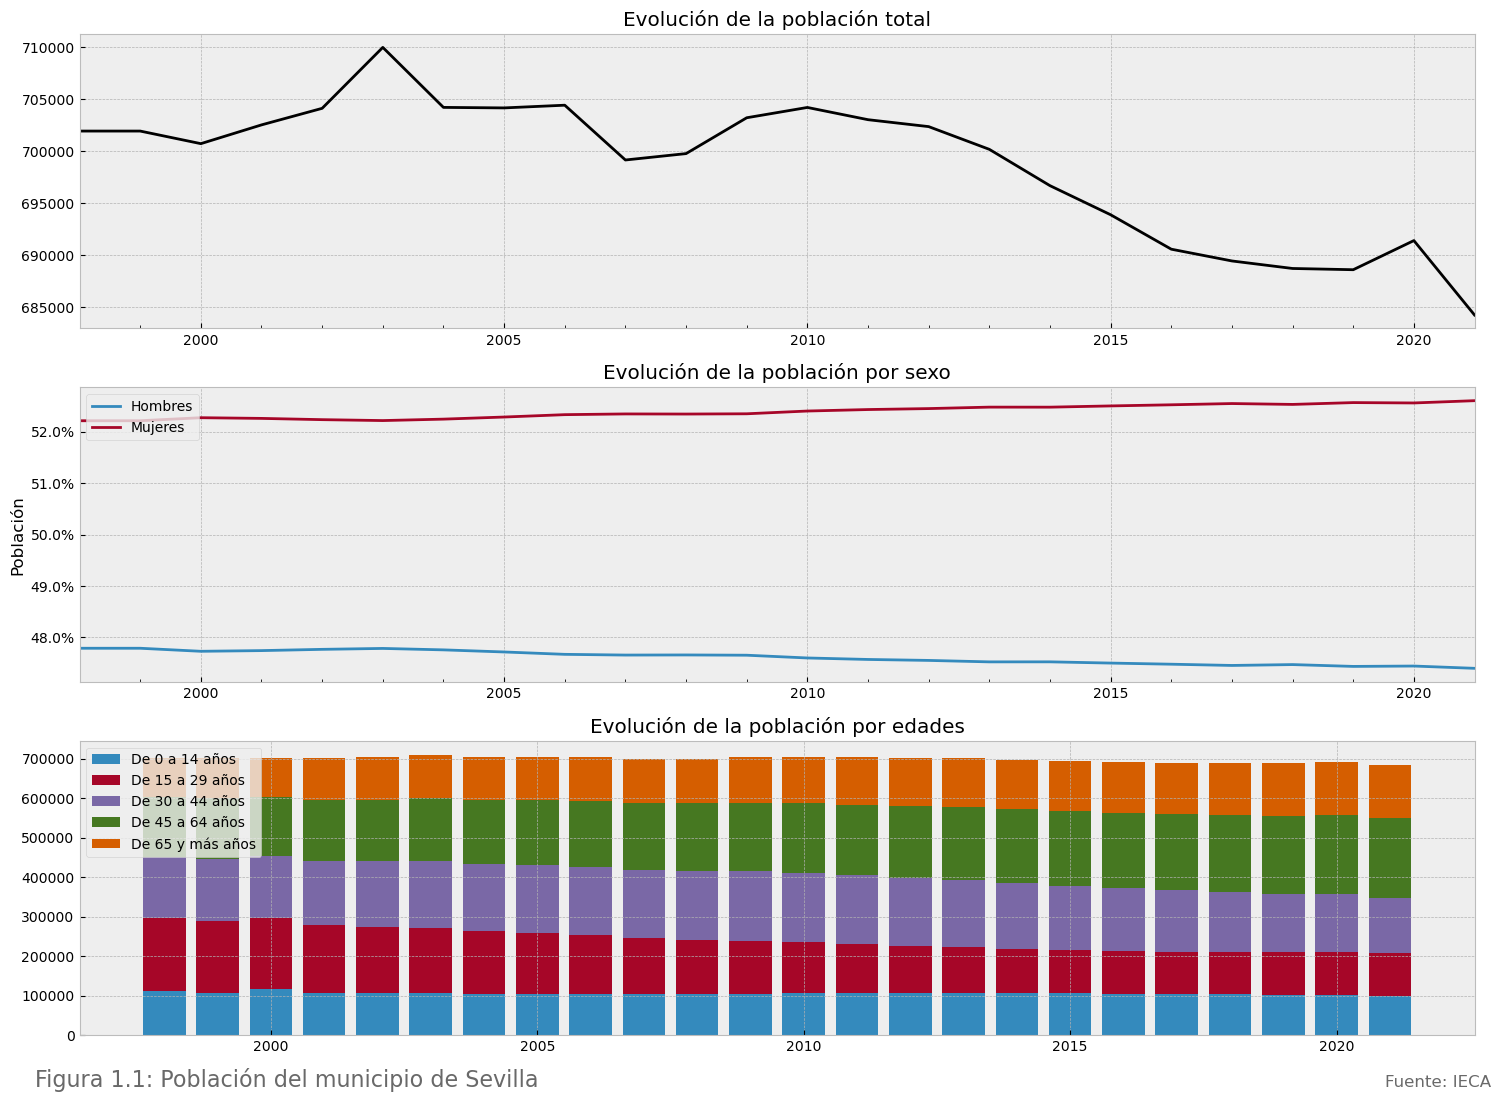

In [12]:
fig, axs = plt.subplots(3, 1,figsize=(18,13))

poblacion['Total'].plot(ax=axs[0], color='#000000')
axs[0].set_title('Evolución de la población total')

poblacion['Hombres'].plot(ax=axs[1], label='Hombres')
poblacion['Mujeres'].plot(ax=axs[1], label='Mujeres')
axs[1].set_title('Evolución de la población por sexo')
axs[1].set(ylabel='Población')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[1].legend(loc='upper left')

axs[2].bar(list(poblacion_edad.index.year), poblacion_edad['De 0 a 14 años'], label='De 0 a 14 años')
axs[2].bar(list(poblacion_edad.index.year), poblacion_edad['De 15 a 29 años'], label='De 15 a 29 años', bottom=poblacion_edad['De 0 a 14 años'])
axs[2].bar(list(poblacion_edad.index.year), poblacion_edad['De 30 a 44 años'], label='De 30 a 44 años', bottom=poblacion_edad['De 0 a 14 años']+poblacion_edad['De 15 a 29 años'])
axs[2].bar(list(poblacion_edad.index.year), poblacion_edad['De 45 a 64 años'], label='De 45 a 64 años', bottom=poblacion_edad['De 0 a 14 años']+poblacion_edad['De 15 a 29 años']+poblacion_edad['De 30 a 44 años'])
axs[2].bar(list(poblacion_edad.index.year), poblacion_edad['De 65 y más años'], label='De 65 y más años', bottom=poblacion_edad['De 0 a 14 años']+poblacion_edad['De 15 a 29 años']+poblacion_edad['De 30 a 44 años']+poblacion_edad['De 45 a 64 años'])
axs[2].set_title('Evolución de la población por edades')
axs[2].legend(loc='upper left')

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 1.1: Población del municipio de Sevilla', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Población/grafico11.png', dpi=1200)

plt.show()

En la figura 1.1 podemos ver gráficamente la evolución a lo largo de los años la población en el municipio, siendo lo más marcado el estancamiento, y posterior descenso de la población en el municipio, pudiendo deberse al crecimiento de las ciudades de alrededor que conforman el área metropolitana, actuándo de ciudades dormitorio.

La distribución por edades tal y como habíamos mencionado anteriormente ha ido creciendo en los grupos de edades mayores. En el último gráfico de la figura 1.1 podemos observarlo de una forma más intuitiva, donde el grupo de 45 a 64 años cada vez es mayor.

___

> <a id='Esquema'>2. Esquema general de la metodologia</a>

A lo largo de esta sección definiremos las principales prácticas de análisis que hemos usado para la realización de este informe. También mencionar las fuentes de datos han sido principalmente el *Instituto de Estadística y Cartografía de Anadalucía*, entre algunas otras como el *Observatorio ARGOS*, del Servicio Andaluz de Empleo.

<a id='Esquema1'>2.1. Programación y definición de funciones</a>

El principal recurso usado es el lenguaje de programación *Python*, así como distintas librerías de uso libre, tanto para la representación de tablas, como otras que sirven para el cálculo estadístico y de modelaje. El procedimiento ha sido siempre de una forma estructurada dónde definíamos diversas funciones de uso común a lo largo de todas las secciones, como la desestacionalización de las series, el cálculo de las tasas de variación, entre otras. El objetivo de ésto ha sido simplificar y poder poner en práctica herramientas disponibles, las cuales me serán de gran utilidad para futuros análisis.

Otro recurso ha sido el entorno de programación, que en *Python* nos encontramos numerosos entornos (a diferencia de Stata, MATLAB, etc.) que para nosotros el más correcto ha sido *Jupyter Notebook*, un entorno con base en HTML el cuál nos permite poder realizar una estructura de informe al mismo tiempo que estamos programando y realizando los distintos análisis.

<a id='Esquema2'>2.2. Relleno de valores perdidos o no disponibles</a>

Para el relleno de valores perdidos debemos tener en cuenta varios factores, pero entre ello dos resaltan sobre el resto. Primero sería qué cantidad de valores nulos o perdidos tenemos, ya que si contamos con una serie temporal, la cual la mitad de sus valores no los disponemos, tal vez no podamos hacer nada respecto a ello; ya que, independiente de cuál método usemos no encontraremos una forma de rellenarlo de forma eficaz.

Lo segundo sería qué método de rellenado vamos a usar, existen diversas formas y librerías dentro de *Python* donde podemos encontrar métodos lineales, no lineales, por la media o distintos estadísticos sobre el pasado o incluso futuro (si hay valores previos o futuros al valor perdido) sobre la misma serie.

Nosotros vamos a centrarnos en dos de ellos, el lineal y el cudrático para ver cual es la diferencia a nivel visual.

In [13]:
# IMPORTAMOS PRECIOS HOTELEROS PARA PODER IDENTIFICAR CUAL ES EL MEJOR MÉTODO DE RELLENO DE NaNs

precios_hoteles = pd.read_excel(datos + 'Turismo/indice_precios_hoteleros_provincial.xlsx', 'Precios'
                                  , index_col=0, parse_dates=True)

precios_hoteles.index = pd.PeriodIndex(precios_hoteles.index, freq='M')

ValueError: zero-size array to reduction operation fmin which has no identity

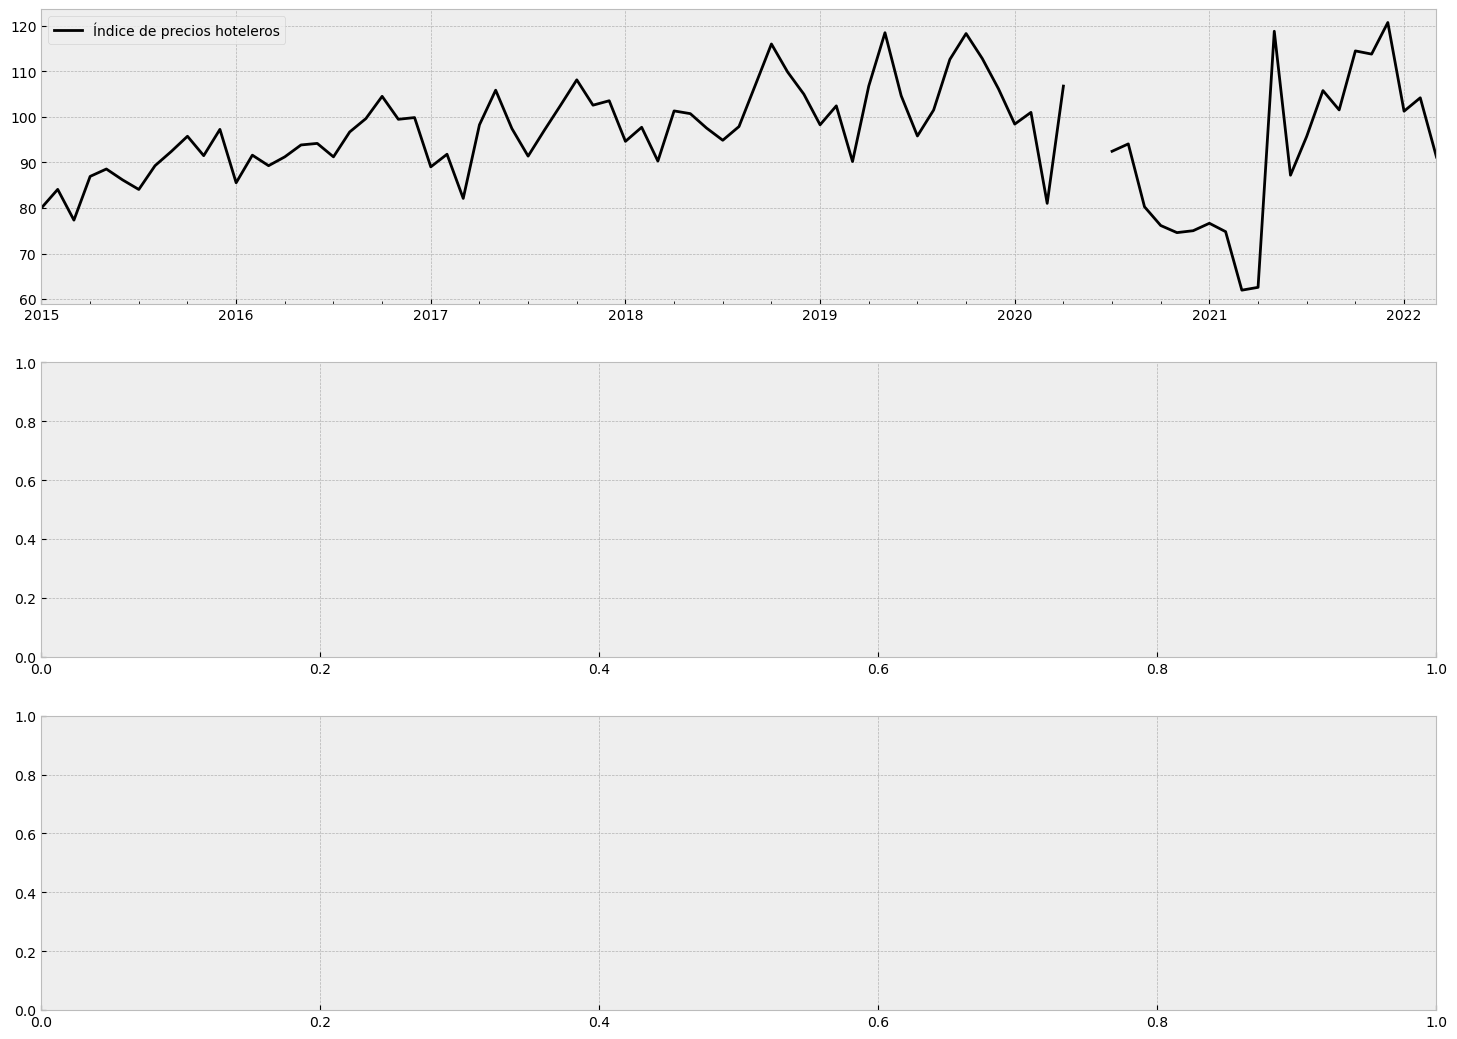

In [14]:
# Comparación de metodología de relleno de missing values

y = precios_hoteles.copy()
y.index = y.index.to_timestamp()
y = y.interpolate(method='polynomial', order=2)
z = precios_hoteles.copy().fillna(method='ffill')

fig, axs = plt.subplots(3, 1,figsize=(18,13))

precios_hoteles.iloc[:136].plot(ax=axs[0], color='#000000')
precios_hoteles.iloc[136:138].plot(ax=axs[0], color='r')
precios_hoteles.iloc[138:].plot(ax=axs[0], color='#000000')
axs[0].set_title('Índice de precios hoteleros')
axs[0].legend().set_visible(False)

y.iloc[:136].plot(ax=axs[1], color='#000000')
y.iloc[135:139].plot(ax=axs[1], color='r')
y.iloc[138:].plot(ax=axs[1], color='#000000')
axs[1].set_title('Método "interpolate()" de pandas')
axs[1].legend().set_visible(False)

z.iloc[:136].plot(ax=axs[2], color='#000000')
z.iloc[135:139].plot(ax=axs[2], color='r')
z.iloc[138:].plot(ax=axs[2], color='#000000')
axs[2].set_title('Método "ffill" de pandas')
axs[2].legend().set_visible(False)

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 2.1: Comparación de relleno de valores nulos', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Metodología/grafico21.png', dpi=1200)

plt.show()

del y, z, precios_hoteles

Como podemos observar en la figura 2.1, el método "*interpolate()*" usa una aproximación cuadrática, mientras que el método "*ffill()*", utiliza una aproximación lineal, dónde claramente, la primera parece rellenar correctamente la continuidad y estacionalidad del pasado de la serie sobre el índice de precios hoteleros.

___

> <a id='Empresas'>3. Análisis del número de empresas</a>

En esta sección trataremos de analizar número de empresas divididos actividades según CNAE-09, así como el Índice de Precios a nivel provincial (no se realiza a nivel municipal), el cual nos puede ayudar a mostrarnos la evolución de los posibles precios en el municpio de Sevilla.

A través del número de empresas podremos observar como algunos sectores tienen más peso que otros y su posible crecimientos, siempre sin tener en cuenta los rendimientos de éstas por lo que no podremos saber más allá de los datos de los que disponemos.

In [ ]:
###############################
# EMPRESAS POR CÓDIGO CNAE-09 #
###############################


################################################################################################################################


# IMPORTAMOS NÚMERO DE EMPRESAS (TRIMESTRAL)
n_empresas = pd.read_excel(datos + 'Empresas/n_empresas_CNAE09.xls', 'Empresas', index_col=0, parse_dates=True)
n_empresas.index = pd.PeriodIndex(n_empresas.index, freq='Q')                      # Convertimos a formato legible el índice


# TASAS DE VARIACIÓN NÚMERO DE EMPRESAS
tv_empresas = tv(n_empresas)


# TASAS DE VARIACIÓN NÚMERO DE EMPRESAS ANUAL
tv_empresas_anual = tv_anual(n_empresas)


################################################################################################################################


# NÚMERO DE EMPRESAS DESESTACIONALIZADO
n_empresas_deses = deses(n_empresas)                                               # Utilizamos la función que
                                                                                   # habíamos definido

# TASA DE VARIACIÓN NÚMERO DE EMPRESAS DESESTACIONALIZADO
tv_empresas_deses = tv(n_empresas_deses)
                                                                                   # Para la tasa de variación anual
                                                                                   # no hace falta desestacionalizar
                                                                                   # no existe un factor estacional

<a id='Empresas1'>3.1. Número de empresas total y por actividades</a>

En esta sección veremos la evolución del número de empresas. Nuestro principal foco será observar que sectores de la economía sevillana pueden parecer indicar que están recuperándose de la crisis del COVID-19 y si éstas se encuentran en niveles antes de la crisis.

In [ ]:
# Tabla de empresas en los últimos años
t_tv_empresas = tv_empresas_anual.iloc[6:, :].T.copy()
t_tv_empresas.columns = ["2018", "2019", "2020", "2021"]


tabla_tv_empresas = t_tv_empresas.style

tabla_tv_empresas.format(formatter="{:.2%}")

tabla_tv_empresas.set_table_styles([cell_hover, index_names, headers])

tabla_tv_empresas.set_caption('Tabla 3.1: Tasa de variación anual de empresas según código CNAE')\
 .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

In [ ]:
#################
# GUARDAR TABLA #
#################
#dfi.export(tabla_tv_empresas, 'Tablas/Empresas y precios/tabla31.png')

Tal y como vemos en la tabla 3.1, en los años previos a la crisis del COVID-19, el crecimiento anual del número de empresas totales ha sido positivo, no especialmente grande pero sí significativo. Los sectores económicos más relevantes serían la Agricultura, las Actividades artísticas, recreativas y de entretenimiento, así como la Construcción y Actividades Inmobiliarias.

En el 2020 se observa como de forma general todos los sectores se vieron afectados por las restricciones, aunque se percibe en la última partida la creación de nuevas empresas por partes de los organismos públicos; así como otras industrias.

In [ ]:
# Número de empresas totales y desestacionalizado, con la tasa de variación trimestral y desestacionalizado,
# y tasa de variación anual
fig, axs = plt.subplots(3, 1,figsize=(18,13))

n_empresas['Total'].plot(ax=axs[0], label='Serie normal')
n_empresas_deses['Total'].plot(ax=axs[0], label='Serie desestacionalizada')
axs[0].set_title('Evolución del número de empresas totales')
axs[0].legend(loc='upper left')

tv_empresas['Total'].plot(ax=axs[1])
tv_empresas_deses['Total'].plot(ax=axs[1])
axs[1].set_title('Tasa de variación trimestrales del número de empresas totales')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

tv_empresas_anual['Total'].plot(ax=axs[2])
axs[2].set_title('Tasa de variación anuales del número de empresas totales')
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))


plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 3.1: Evolución del número de empresas totales en el municipio de Sevilla'
            , fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Empresas y precios/grafico31.png', dpi=1200)

plt.show()

Tal y como habíamos mencionado anteriormente, en la figura 3.1 seguimos observando como el crecimiento durante los últimos años del número de empresas en Sevilla había sido constante, siendo éste positivo a partir de la segunda mitad de 2013, donde ya se vería la recuperación de la crisis de 2011 en el muncipio.

Los siguientes trimestres a la crisis se observa una aproximación a niveles previos a la crisis, incluso manteniendo un crecimiento aparentemente estable a partir de la segunda mitad del 2020.

A continuación vamos a tratar de analizar la evolución para sectores que mantenían un número alto y estable de empresas a lo largo de los años que disponemos en la serie. Nos encontraríamos con sectores tales como: Comercio, Hostelería, Construcción y Actividades profesionales, científicas y técnicas.

In [ ]:
# Representamos variación número de empresas total y por industria
fig, axs = plt.subplots(4, 1,figsize=(18,18))

n_empresas['Comercio'].plot(ax=axs[0], label='Serie normal')
n_empresas_deses['Comercio'].plot(ax=axs[0], label='Serie desestacionalizada')
axs[0].set_title('Evolución del número de empresas de Comercio')
axs[0].legend(loc='lower left')


n_empresas['Hostelería'].plot(ax=axs[1])
n_empresas_deses['Hostelería'].plot(ax=axs[1])
axs[1].set_title('Evolución del número de empresas de Hostelería')

n_empresas['Construcción'].plot(ax=axs[2])
n_empresas_deses['Construcción'].plot(ax=axs[2])
axs[2].set_title('Evolución del número de empresas de Construcción')

n_empresas['Actividades profesionales, científicas y técnicas'].plot(ax=axs[3])
n_empresas_deses['Actividades profesionales, científicas y técnicas'].plot(ax=axs[3])
axs[3].set_title('Evolución del número de empresas de Actividades profesionales, científicas y técnicas')

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 3.2: Evolución del número de empresas en distintos grupos en el municipio de Sevilla'
            , fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Empresas y precios/grafico32.png', dpi=1200)

plt.show()

En la figura 3.2 observamos comportamientos parecidos así como contrarios. El grupo de la hostelería es e que más de dispersa del resto de sectores, donde en el año 2011 a 2012 desaparecieron alrededor de 500 empresas en un solo año, casi de manera instantánea. En el resto de sectores, durante ese mismo año crecieron, pero observándose una caída posteriormente, aunque más progresiva.

Sectores como el Comercio o la Construcción no han podido recuperarse a niveles previos a la crisis de 2011, incluso antes de la crisis provocada por la pandemia. Las empresas dedicada a las actividades profesionales, científicas y técnicas, no sólo tuvieron un "shock" menor en el 2020, sino que crecieron rápidamente al siguiente año.

Los sectores del Comercio, Hostelería y Construcción son sectores que en el municipio sevillano tienen una alta estacionalidad, no siendo una realidad muy distinta en el resto de España, y, especialmente Andalucía.

In [ ]:
# Representamos variación número de empresas total y por industria desestacionalizado
fig, axs = plt.subplots(2, 1,figsize=(18,10))

tv_empresas['Comercio'].plot(ax=axs[0], label='Comercio')
tv_empresas['Hostelería'].plot(ax=axs[0], label='Hostelería')
tv_empresas['Construcción'].plot(ax=axs[0], label='Construcción')
tv_empresas['Actividades profesionales, científicas y técnicas'].plot(ax=axs[0], label='Actividades profesionales, etc.')
axs[0].set_title('Tasas de variación del número de empresas por grupos seleccionados')
axs[0].legend(loc='upper left')

tv_empresas_deses['Comercio'].plot(ax=axs[1], label='Comercio')
tv_empresas_deses['Hostelería'].plot(ax=axs[1], label='Hostelería')
tv_empresas_deses['Construcción'].plot(ax=axs[1], label='Construcción')
tv_empresas_deses['Actividades profesionales, científicas y técnicas'].plot(ax=axs[1], label='Actividades profesionales, etc.')
axs[1].set_title('Tasas de variación del número de empresas desestacionalizado por grupos seleccionados')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 3.3: Tasas de variación en distintos grupos de empresas en el municipio de Sevilla'
            , fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Empresas y precios/grafico33.png', dpi=1200)

plt.show()

Observando las tasas de variaciones de los sectores que hemos analizado anteriormente, vemos en la figura 3.3, como todos los sectores han mantenido crecimientos muy similares, donde ya mencionamos antes la menor variabilidad del sector de las Actividades profesionales. La Construcción como vemos, es un sector que a lo largo de los periodos seleccionados parece tener cambios especialmente bruscos, respecto a los otros sectores representados.

<a id='Empresas3'>3.2. Análisis y predicciones futuras</a>




**Predicción SARIMA**

In [ ]:
# Variable objetivo
varobj = n_empresas['Total'].copy()

# Modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(endog=varobj, trend='c', order=(3,1,2), seasonal_order=(1,0,1,4)).fit()

# Modelo y predicciones del número de empresas
fig, axs = plt.subplots(2, 1,figsize=(18,13))

varobj.plot(ax=axs[0], label='Serie original')
mod.predict().iloc[1:].plot(ax=axs[0], label='Predicción modelo')
axs[0].set_title('Modelo SARIMA')
axs[0].legend(loc="upper left")

pd.concat([varobj, mod.get_forecast(steps=12).summary_frame()['mean'].iloc[:1]]).plot(x=axs[1])
mod.get_forecast(steps=12).summary_frame()['mean'].plot(x=axs[1], style='--')
axs[1].fill_between(mod.get_forecast(steps=12).summary_frame().index
                    , mod.get_forecast(steps=12).summary_frame()['mean_ci_lower']
                    , mod.get_forecast(steps=12).summary_frame()['mean_ci_upper']
                    , color='k', alpha=0.05)
axs[1].text(200, 20000, 'Desviación estándar relativa: ' + str("{0:.2%}".format(((varobj.iloc[1:]-mod.predict().iloc[1:])**2).mean()**(1/2)/varobj.iloc[1:].mean())), bbox=dict(facecolor='lightgray', alpha=0.4, edgecolor='k'))
axs[1].set_title('Predicción modelo')

plt.figtext(.85, .07, 'Elaboración propia', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 3.4: Número de empresas y modelo SARIMA', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Empresas y precios/grafico34.png', dpi=1200)

plt.show()


In [ ]:
del varobj

___

> <a id='Turismo'>4. Turismo</a>

Texto

In [ ]:
###########################################################################
# TURISMO NACIONAL, EXTRANJERO Y TOTAL: VIAJEROS Y PERCNOTACIONES TOTALES #
###########################################################################


################################################################################################################################


# IMPORTAMOS LOS DATOS MENSUALES DEL TURISMO NACIONAL
turismo_nacional = pd.read_excel(datos + 'Turismo/turismo.xlsx', 'Residentes en España', index_col=0, parse_dates=True)

turismo_nacional.index = pd.PeriodIndex(turismo_nacional.index, freq='M')     # Pasamos a formato correcto el índice


# IMPORTAMOS LOS DATOS MENSUALES DEL TURISMO INTERNACIONAL
turismo_extranjero = pd.read_excel(datos + 'Turismo/turismo.xlsx', 'Residentes en el Extrajero', index_col=0, parse_dates=True)

turismo_extranjero.index = pd.PeriodIndex(turismo_extranjero.index, freq='M') # Pasamos a formato correcto el índice


# SUMAMOS AMBOS PARA CONSEGUIR EL TOTAL
turismo = turismo_nacional + turismo_extranjero


################################################################################################################################


# PASAMOS A TRIMESTRAL
# TURISMO NACIONAL
turismo_nacional_Q = trimes(turismo_nacional, 's')

# TURISMO INTERNACIONAL
turismo_extranjero_Q = trimes(turismo_extranjero, 's')

# TURISMO TOTAL
turismo_Q = trimes(turismo, 's')


################################################################################################################################


# DESESTACIONALIZAMOS

# DATOS MENSUALES
turismo_nacional_deses = deses(turismo_nacional)

turismo_extranjero_deses = deses(turismo_extranjero)

turismo_deses = deses(turismo)


# DATOS TRIMESTRALES
turismo_nacional_deses_Q = deses(turismo_nacional_Q)

turismo_extranjero_deses_Q = deses(turismo_extranjero_Q)

turismo_deses_Q = deses(turismo_Q)


################################################################################################################################

# TASAS DE VARIACIÓN
# MENSUAL
tv_turismo_nacional = tv(turismo_nacional)

tv_turismo_extranjero = tv(turismo_extranjero)

tv_turismo = tv(turismo)

# INTERANUAL
tv_turismo_nacional_anual = tv_anual(turismo_nacional)

tv_turismo_extranjero_anual = tv_anual(turismo_extranjero)

tv_turismo_anual = tv_anual(turismo)

# TRIMESTRAL
tv_turismo_nacional_Q = tv(turismo_nacional_Q)

tv_turismo_extranjero_Q = tv(turismo_extranjero_Q)

tv_turismo_Q = tv(turismo_Q)


# DESESTACIONALIZADO
# Mensual
tv_turismo_nacional_deses = tv(turismo_nacional_deses)

tv_turismo_extranjero_deses = tv(turismo_extranjero_deses)

tv_turismo_deses = tv(turismo_deses)

# Trimestral
tv_turismo_nacional_deses_Q = tv(turismo_nacional_deses_Q)

tv_turismo_extranjero_deses_Q = tv(turismo_extranjero_deses_Q)

tv_turismo_deses_Q = tv(turismo_deses_Q)


In [ ]:
# Tabla de evolución de la inflación de hoteles y turistas

tabla_turismo = tv_turismo_anual.iloc[12:].style

tabla_turismo.format(thousands=" ", formatter={
    'Viajeros':'{:.2%}',
    'Pernoctaciones':'{:.2%}'})

tabla_turismo.format_index(lambda v: v.strftime("%Y"))

tabla_turismo.set_table_styles([cell_hover, index_names, headers])

tabla_turismo.set_caption("Tabla 4.1: Tasa de variación anual del turismo y precios hoteleros")\
 .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

In [ ]:
#################
# GUARDAR TABLA #
#################
#dfi.export(tabla_turismo, 'Tablas/Turismo/tabla41.png')

<a id='Turismo1'>4.1. Turismo nacional y extranjero</a>

In [ ]:
# Representamos turismo nacional, extranjero y total
fig, axs = plt.subplots(2, 1,figsize=(18,13))

turismo_nacional_deses['Viajeros'].plot(ax=axs[0], label='Turismo nacional desestacionalizado')
turismo_extranjero_deses['Viajeros'].plot(ax=axs[0], label='Turismo extranjero desestacionalizado')
axs[0].set_title('Evolución del turismo nacional y extranjero')
axs[0].legend(loc="upper left")

tv_turismo_nacional_deses['Viajeros'].plot(ax=axs[1], label='Turismo nacional desestacionalizado')
tv_turismo_extranjero_deses['Viajeros'].plot(ax=axs[1], label='Turismo extranjero desestacionalizado')
axs[1].set_title('Evolución de la tasa de variación del turismo nacional y extranjero')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))


plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 4.1: Turismo nacional y extranjero en el municipio de Sevilla', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Turismo/grafico41.png', dpi=1200)

plt.show()

<a id='Turismo2'>4.2. Evolución de las percnotaciones</a>

<a id='Turismo3'>4.3. Análisis y predicciones futuras</a>

**Predicción SARIMA**

In [ ]:
# Variable objetivo
varobj = turismo['Viajeros'].copy()

# Modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(endog=varobj, trend='c', order=(3,0,2), seasonal_order=(1,0,1,12)).fit()

# Modelo y predicciones del número de empresas
fig, axs = plt.subplots(2, 1,figsize=(18,13))

varobj.plot(ax=axs[0], label='Serie original')
mod.predict().iloc[1:].plot(ax=axs[0], label='Predicción modelo')
axs[0].set_title('Modelo SARIMA')
axs[0].legend(loc="upper left")

pd.concat([varobj, mod.get_forecast(steps=24).summary_frame()['mean'].iloc[:1]]).plot(x=axs[1])
mod.get_forecast(steps=24).summary_frame()['mean'].plot(x=axs[1], style='--')
axs[1].fill_between(mod.get_forecast(steps=24).summary_frame().index
                    , mod.get_forecast(steps=24).summary_frame()['mean_ci_lower']
                    , mod.get_forecast(steps=24).summary_frame()['mean_ci_upper']
                    , color='k', alpha=0.05)
axs[1].text(425, 10000, 'Desviación estándar relativa: ' + str("{0:.2%}".format(((varobj.iloc[1:]-mod.predict().iloc[1:])**2).mean()**(1/2)/varobj.iloc[1:].mean())), bbox=dict(facecolor='lightgray', alpha=0.4, edgecolor='k'))
axs[1].set_title('Predicción modelo')

plt.figtext(.85, .07, 'Elaboración propia', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 4.4: Número de turistas y modelo SARIMA', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Análisis/grafico44.png', dpi=1200)

plt.show()


In [ ]:
del varobj

___

> <a id='Trabajo'>5. Análisis de las variables en el mercado laboral</a>

In [ ]:
############################
# AFILIACIONES POR RÉGIMEN #
############################


################################################################################################################################


# AMBOS SEXOS
afiliaciones_por_regimen = pd.read_excel(datos + 'Mercado de Trabajo/Afiliaciones/afiliaciones_por_regimen.xlsx'
                                         , 'Ambos sexos', index_col=0, parse_dates=True)
afiliaciones_por_regimen.index = pd.PeriodIndex(afiliaciones_por_regimen.index, freq='Q')

# HOMBRES
afiliaciones_por_regimen_hombres = pd.read_excel(datos + 'Mercado de Trabajo/Afiliaciones/afiliaciones_por_regimen.xlsx'
                                                 , 'Hombres', index_col=0, parse_dates=True)
afiliaciones_por_regimen_hombres.index = pd.PeriodIndex(afiliaciones_por_regimen_hombres.index, freq='Q')


# MUJERES
afiliaciones_por_regimen_mujeres = pd.read_excel(datos + 'Mercado de Trabajo/Afiliaciones/afiliaciones_por_regimen.xlsx'
                                                 , "Mujeres", index_col=0, parse_dates=True)
afiliaciones_por_regimen_mujeres.index = pd.PeriodIndex(afiliaciones_por_regimen_mujeres.index, freq='Q')


################################################################################################################################

# DESESTACIONALIZAMOS
# AMBOS SEXOS
afiliaciones_por_regimen_deses = deses(afiliaciones_por_regimen)

# HOMBRES
afiliaciones_por_regimen_hombres_deses = deses(afiliaciones_por_regimen_hombres)

# MUJERES
afiliaciones_por_regimen_mujeres_deses = deses(afiliaciones_por_regimen_mujeres)


################################################################################################################################

# TASAS DE VARIACIÓN

# INTERNUAL
# AMBOS SEXOS
tv_afiliaciones_por_regimen_anual = tv_anual(afiliaciones_por_regimen)

# HOMBRES
tv_afiliaciones_por_regimen_hombres_anual = tv_anual(afiliaciones_por_regimen_hombres)

# MUJERES
tv_afiliaciones_por_regimen_mujeres_anual = tv_anual(afiliaciones_por_regimen_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
tv_afiliaciones_por_regimen = tv(afiliaciones_por_regimen)

# HOMBRES
tv_afiliaciones_por_regimen_hombres = tv(afiliaciones_por_regimen_hombres)

# MUJERES
tv_afiliaciones_por_regimen_mujeres = tv(afiliaciones_por_regimen_mujeres)


# TRIMESTRAL DESESTACIONALIZADO
tv_afiliaciones_por_regimen_deses = tv(afiliaciones_por_regimen_deses)

# HOMBRES
tv_afiliaciones_por_regimen_hombres_deses = tv(afiliaciones_por_regimen_hombres_deses)

# MUJERES
tv_afiliaciones_por_regimen_mujeres_deses = tv(afiliaciones_por_regimen_mujeres_deses)


In [ ]:
######################################
# AFILIACIONES POR RAMA DE ACTIVIDAD #
######################################


################################################################################################################################


# AMBOS SEXOS
afiliaciones_por_actividad = pd.read_excel(datos + "Mercado de Trabajo/Afiliaciones/afiliaciones_por_rama_de_actividad.xlsx"
                                           , "Ambos sexos", index_col=0, parse_dates=True)
afiliaciones_por_actividad.index = pd.PeriodIndex(afiliaciones_por_actividad.index, freq='Q')

# HOMBRES
afiliaciones_por_actividad_hombres = pd.read_excel(datos + "Mercado de Trabajo/Afiliaciones/afiliaciones_por_rama_de_actividad.xlsx"
                                                   , "Hombres", index_col=0, parse_dates=True)
afiliaciones_por_actividad_hombres.index = pd.PeriodIndex(afiliaciones_por_actividad_hombres.index, freq='Q')

# MUJERES
afiliaciones_por_actividad_mujeres = pd.read_excel(datos + "Mercado de Trabajo/Afiliaciones/afiliaciones_por_rama_de_actividad.xlsx"
                                                   , "Mujeres", index_col=0, parse_dates=True)
afiliaciones_por_actividad_mujeres.index = pd.PeriodIndex(afiliaciones_por_actividad_mujeres.index, freq='Q')


################################################################################################################################

# DESESTACIONALIZAMOS
# AMBOS SEXOS
afiliaciones_por_actividad_deses = deses(afiliaciones_por_actividad)

# HOMBRES
afiliaciones_por_actividad_hombres_deses = deses(afiliaciones_por_actividad_hombres)

# MUJERES
afiliaciones_por_actividad_mujeres_deses = deses(afiliaciones_por_actividad_mujeres)


################################################################################################################################

# TASAS DE VARIACIÓN

# INTERNUAL
# AMBOS SEXOS
tv_afiliaciones_por_actividad_anual = tv_anual(afiliaciones_por_actividad)

# HOMBRES
tv_afiliaciones_por_actividad_hombres_anual = tv_anual(afiliaciones_por_actividad_hombres)

# MUJERES
tv_afiliaciones_por_actividad_mujeres_anual = tv_anual(afiliaciones_por_actividad_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
tv_afiliaciones_por_actividad = tv(afiliaciones_por_actividad)

# HOMBRES
tv_afiliaciones_por_actividad_hombres = tv(afiliaciones_por_actividad_hombres)

# MUJERES
tv_afiliaciones_por_actividad_mujeres = tv(afiliaciones_por_actividad_mujeres)


# TRIMESTRAL DESESTACIONALIZADO
tv_afiliaciones_por_actividad_deses = tv(afiliaciones_por_actividad_deses)

# HOMBRES
tv_afiliaciones_por_actividad_hombres_deses = tv(afiliaciones_por_actividad_hombres_deses)

# MUJERES
tv_afiliaciones_por_actividad_mujeres_deses = tv(afiliaciones_por_actividad_mujeres_deses)


In [ ]:
#########################
# CONTRATOS REGISTRADOS #
#########################


################################################################################################################################


# AMBOS SEXOS
contratos_registrados = pd.read_excel(datos + "Mercado de Trabajo/contratos_registrados.xlsx"
                                      , "Ambos sexos", index_col=0, parse_dates=True)

contratos_registrados.index = pd.PeriodIndex(contratos_registrados.index, freq='M')

# HOMBRES
contratos_registrados_hombres = pd.read_excel(datos + "Mercado de Trabajo/contratos_registrados.xlsx"
                                              , "Hombres", index_col=0, parse_dates=True)

contratos_registrados_hombres.index = pd.PeriodIndex(contratos_registrados_hombres.index, freq='M')

# MUJERES
contratos_registrados_mujeres = pd.read_excel(datos + "Mercado de Trabajo/contratos_registrados.xlsx"
                                              , "Mujeres", index_col=0, parse_dates=True)

contratos_registrados_mujeres.index = pd.PeriodIndex(contratos_registrados_mujeres.index, freq='M')


################################################################################################################################

# CONVERTIMOS A TRIMESTRAL
# AMBOS SEXOS
contratos_registrados_Q = trimes(contratos_registrados, 's')

# HOMBRES
contratos_registrados_hombres_Q = trimes(contratos_registrados_hombres, 's')

# MUJERES
contratos_registrados_mujeres_Q = trimes(contratos_registrados_mujeres, 's')

################################################################################################################################

# DESESTACIONALIZAMOS

# MENSUAL
# AMBOS SEXOS
contratos_registrados_deses = deses(contratos_registrados)

# HOMBRES
contratos_registrados_hombres_deses = deses(contratos_registrados_hombres)

# MUJERES
contratos_registrados_mujeres_deses = deses(contratos_registrados_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
contratos_registrados_deses_Q = deses(contratos_registrados_Q)

# HOMBRES
contratos_registrados_hombres_deses_Q = deses(contratos_registrados_hombres_Q)

# MUJERES
contratos_registrados_mujeres_deses_Q = deses(contratos_registrados_mujeres_Q)


################################################################################################################################

# TASAS DE VARIACIÓN

# INTERANUAL
# AMBOS SEXOS
tv_contratos_registrados_anual = tv_anual(contratos_registrados)

# HOMBRES
tv_contratos_registrados_hombres_anual = tv_anual(contratos_registrados_hombres)

# MUJERES
tv_contratos_registrados_mujeres_anual = tv_anual(contratos_registrados_mujeres)


# MENSUAL
# AMBOS SEXOS
tv_contratos_registrados = tv(contratos_registrados)

# HOMBRES
tv_contratos_registrados_hombres = tv(contratos_registrados_hombres)

# MUJERES
tv_contratos_registrados_mujeres = tv(contratos_registrados_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
tv_contratos_registrados_Q = tv(contratos_registrados_Q)

# HOMBRES
tv_contratos_registrados_hombres_Q = tv(contratos_registrados_hombres_Q)

# MUJERES
tv_contratos_registrados_mujeres_Q = tv(contratos_registrados_mujeres_Q)


# MENSUAL DESESTACIONALIZADO
# AMBOS SEXOS
tv_contratos_registrados_deses = tv(contratos_registrados_deses)

# HOMBRES
tv_contratos_registrados_hombres_deses = tv(contratos_registrados_hombres_deses)

# MUJERES
tv_contratos_registrados_mujeres_deses = tv(contratos_registrados_mujeres_deses)


# TRIMESTRAL DESESTACIONALIZADO
# AMBOS SEXOS
tv_contratos_registrados_deses_Q = tv(contratos_registrados_deses_Q)

# HOMBRES
tv_contratos_registrados_hombres_deses_Q = tv(contratos_registrados_hombres_deses_Q)

# MUJERES
tv_contratos_registrados_mujeres_deses_Q = tv(contratos_registrados_mujeres_deses_Q)


In [ ]:
#######################################
# DEMANDA DE EMPLEO Y PARO REGISTRADO #
#######################################


################################################################################################################################


# AMBOS SEXOS
empleo = pd.read_excel(datos + "Mercado de Trabajo/demanda_empleo_y_paro_registrado.xlsx"
                       , "Ambos sexos", index_col=0, parse_dates=True)

empleo.index = pd.PeriodIndex(empleo.index, freq='M')

# HOMBRES
empleo_hombres = pd.read_excel(datos + "Mercado de Trabajo/demanda_empleo_y_paro_registrado.xlsx"
                               , "Hombres", index_col=0, parse_dates=True)

empleo_hombres.index = pd.PeriodIndex(empleo_hombres.index, freq='M')

# MUJERES
empleo_mujeres = pd.read_excel(datos + "Mercado de Trabajo/demanda_empleo_y_paro_registrado.xlsx"
                               , "Mujeres", index_col=0, parse_dates=True)

empleo_mujeres.index = pd.PeriodIndex(empleo_mujeres.index, freq='M')


################################################################################################################################

# CONVERTIMOS A TRIMESTRAL
# AMBOS SEXOS
empleo_Q = trimes(empleo, 's')

# HOMBRES
empleo_hombres_Q = trimes(empleo_hombres, 's')

# MUJERES
empleo_mujeres_Q = trimes(empleo_mujeres, 's')


################################################################################################################################

# DESESTACIONALIZAMOS

# MENSUAL
# AMBOS SEXOS
empleo_deses = deses(empleo)

# HOMBRES
empleo_hombres_deses = deses(empleo_hombres)

# MUJERES
empleo_mujeres_deses = deses(empleo_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
empleo_deses_Q = deses(empleo_Q)

# HOMBRES
empleo_hombres_deses_Q = deses(empleo_hombres_Q)

# MUJERES
empleo_mujeres_deses_Q = deses(empleo_mujeres_Q)


################################################################################################################################

# TASAS DE VARIACIÓN

# INTERANUAL
# AMBOS SEXOS
tv_empleo_anual = tv_anual(empleo)

# HOMBRES
tv_empleo_hombres_anual = tv_anual(empleo_hombres)

# MUJERES
tv_empleo_mujeres_anual = tv_anual(empleo_mujeres)


# MENSUAL
# AMBOS SEXOS
tv_empleo = tv(empleo)

# HOMBRES
tv_empleo_hombres = tv(empleo_hombres)

# MUJERES
tv_empleo_mujeres = tv(empleo_mujeres)


# TRIMESTRAL
# AMBOS SEXOS
tv_empleo_Q = tv(empleo_Q)

# HOMBRES
tv_empleo_hombres_Q = tv(empleo_hombres_Q)

# MUJERES
tv_empleo_mujeres_Q = tv(empleo_mujeres_Q)


# MENSUAL DESESTACIONALIZADO
# AMBOS SEXOS
tv_empleo_deses = tv(empleo_deses)

# HOMBRES
tv_empleo_hombres_deses = tv(empleo_hombres_deses)

# MUJERES
tv_empleo_mujeres_deses = tv(empleo_mujeres_deses)


# TRIMESTRAL DESESTACIONALIZADO
# AMBOS SEXOS
tv_empleo_deses_Q = tv(empleo_deses_Q)

# HOMBRES
tv_empleo_hombres_deses_Q = tv(empleo_hombres_deses_Q)

# MUJERES
tv_empleo_mujeres_deses_Q = tv(empleo_mujeres_deses_Q)


In [ ]:
################################
# ÍNDICES DE MOVILIDAD LABORAL #
################################


################################################################################################################################


# ÍNDICES DE FLUJOS
indices_flujos = pd.read_excel(datos + "Mercado de Trabajo/Movilidad laboral/indices_de_flujos.xlsx"
                               , "Índice", index_col=0, parse_dates=True)

indices_flujos.index = pd.PeriodIndex(indices_flujos.index, freq='Q')

# ÍDICE DE PERMANENCIA
indice_permanencia = pd.read_excel(datos + "Mercado de Trabajo/Movilidad laboral/indice_de_permanencia.xlsx"
                                   , "Índice", index_col=0, parse_dates=True)

indice_permanencia.index = pd.PeriodIndex(indice_permanencia.index, freq='Q')

# UNIMOS TODOS LOS ÍNDICES
indices_movilidad = indices_flujos.copy()
indices_movilidad.insert(0, "Índice de permanencia", indice_permanencia["Índice de permanencia"])

del indices_flujos, indice_permanencia

################################################################################################################################

# DESESTACIONALIZAMOS

indices_movilidad_deses = deses(indices_movilidad)


################################################################################################################################

# TASAS DE VARIACIÓN
# INTERANUAL
tv_indices_movilidad_anual = tv_anual(indices_movilidad)

# TRIMESTRAL
tv_indices_movilidad = tv(indices_movilidad)

# TRIMESTRAL DESESTACIONALIZADO
tv_indices_movilidad_deses = tv(indices_movilidad_deses)


<a id='Trabajo1'>5.1. Afiliaciones a la Seguridad Social</a>

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,10))

axs[0].pie([afiliaciones_por_regimen.iloc[31, 0],afiliaciones_por_regimen.iloc[31, 1],afiliaciones_por_regimen.iloc[31, 2]
         , afiliaciones_por_regimen.iloc[31, 3], afiliaciones_por_regimen.iloc[31, 4]], autopct='%1.1f%%',
        shadow = True, startangle = 90, labels=['Régimen General y Carbón', 'Sistema Especial Agrario',
       'Empleados del Hogar', 'Autónomos', 'Régimen Especial del Mar'])
axs[0].set_title('Afiliaciones por régimen 2019')
axs[0].axis('equal')

axs[1].pie([afiliaciones_por_regimen.iloc[39, 0],afiliaciones_por_regimen.iloc[39, 1],afiliaciones_por_regimen.iloc[39, 2]
         , afiliaciones_por_regimen.iloc[39, 3], afiliaciones_por_regimen.iloc[39, 4]], autopct='%1.1f%%',
        shadow = True, startangle = 90, labels=['Régimen General y Carbón', 'Sistema Especial Agrario',
       'Empleados del Hogar', 'Autónomos', 'Régimen Especial del Mar'])
axs[1].set_title('Afiliaciones por régimen 2021')
axs[1].axis('equal')

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 5.1: Distribución de las afiliaciones', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Mercado de trabajo/grafico51.png', dpi=1200)

plt.show()


In [ ]:
# Representamos turismo nacional, extranjero y total
fig, axs = plt.subplots(1, 1,figsize=(18,6))

tv_afiliaciones_por_regimen_deses['Régimen General y Carbón'].plot(label='Régimen General y Carbón')
tv_afiliaciones_por_regimen_deses['Sistema Especial Agrario'].plot(label='Sistema Especial Agrario')
tv_afiliaciones_por_regimen_deses['Empleados del Hogar'].plot(label='Empleados del Hogar')
tv_afiliaciones_por_regimen_deses['Autónomos'].plot(label='Autónomos')
tv_afiliaciones_por_regimen_deses['Régimen Especial del Mar'].plot(label='Régimen Especial del Mar')
axs.set_title('Evolución de la tasa de variación de las afiliaciones desestacionalizada')
axs.yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs.legend(loc="upper left")


plt.figtext(.85, .0, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .0, 'Figura 5.2: Afiliaciones por régimen en el municipio de Sevilla', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Mercado de trabajo/grafico52.png', dpi=1200)

plt.show()

In [ ]:
# Tabla de empresas en los últimos años
tabla_afiliaciones = tv_afiliaciones_por_actividad_anual.T[['2018', '2019', '2020', '2021']].style

tabla_afiliaciones.format(formatter='{:.2%}')

tabla_afiliaciones.set_table_styles([cell_hover, index_names, headers])

tabla_afiliaciones.set_caption('Tabla 5.1: Tasa de variación de las afiliaciones por actividad')\
 .set_table_styles([{
     'selector': 'caption',
     'props': 'caption-side: bottom; font-size:1.25em;'
 }], overwrite=False)

In [ ]:
#################
# GUARDAR TABLA #
#################
#dfi.export(tabla_afiliaciones, 'Tablas/Mercado de trabajo/tabla51.png')

<a id='Trabajo2'>5.2. Contratos registrados</a>

In [ ]:
# Representamos turismo nacional, extranjero y total
fig, axs = plt.subplots(3, 1,figsize=(18,16))

contratos_registrados['Indefinidos'].plot(ax=axs[0], label='Serie normal')
contratos_registrados_deses['Indefinidos'].plot(ax=axs[0], label='Serie desestacionalizada')
axs[0].set_title('Contratos indefinidos')
axs[0].legend(loc="upper left")

contratos_registrados['Temporales'].plot(ax=axs[1], label='Serie normal')
contratos_registrados_deses['Temporales'].plot(ax=axs[1], label='Serie desestacionalizada')
axs[1].set_title('Contratos temporales')
axs[1].legend(loc="upper left")

tv_contratos_registrados_deses['Total'].plot(ax=axs[2], label='Total')
tv_contratos_registrados_deses['Indefinidos'].plot(ax=axs[2], label='Indefinidos')
tv_contratos_registrados_deses['Temporales'].plot(ax=axs[2], label='Temporales')
axs[2].set_title('Tasa de variación de los contratos')
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[2].legend(loc="upper left")


plt.figtext(.85, .0, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .0, 'Figura 5.3: Contratos registrado en el municipio de Sevilla', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Mercado de trabajo/grafico53.png', dpi=1200)

plt.show()

In [ ]:
#empleo

<a id='Trabajo3'>5.3. Tasa de actividad, ocupación, desempleo y temporalidad</a>

**Tasa de actividad**

**Tasa de ocupación**

**Tasa de desempleo**

**Tasa de temporalidad**

<a id='Trabajo4'>5.4. Índices de movilidad</a>

In [ ]:
indices_movilidad

<a id='Trabajo5'>5.5. Estudio de las series temporales y predicciones</a>

**Predicción SARIMA**

In [ ]:
# Variable objetivo
varobj = contratos_registrados['Total'].copy()

# Modelo SARIMA
mod = sm.tsa.statespace.SARIMAX(endog=varobj, trend='c', order=(3,1,2), seasonal_order=(1,1,0,12)).fit()

# Modelo y predicciones del número de empresas
fig, axs = plt.subplots(2, 1,figsize=(18,13))

varobj.plot(ax=axs[0], label='Serie original')
mod.predict().iloc[1:].plot(ax=axs[0], label='Predicción modelo')
axs[0].set_title('Modelo SARIMA')
axs[0].legend(loc="upper left")

pd.concat([varobj, mod.get_forecast(steps=24).summary_frame()['mean'].iloc[:1]]).plot(x=axs[1])
mod.get_forecast(steps=24).summary_frame()['mean'].plot(x=axs[1], style='--')
axs[1].fill_between(mod.get_forecast(steps=24).summary_frame().index
                    , mod.get_forecast(steps=24).summary_frame()['mean_ci_lower']
                    , mod.get_forecast(steps=24).summary_frame()['mean_ci_upper']
                    , color='k', alpha=0.05)
axs[1].text(470, 80000, 'Desviación estándar relativa: ' + str("{0:.2%}".format(((varobj.iloc[1:]-mod.predict().iloc[1:])**2).mean()**(1/2)/varobj.iloc[1:].mean())), bbox=dict(facecolor='lightgray', alpha=0.4, edgecolor='k'))
axs[1].set_title('Predicción modelo')

plt.figtext(.85, .07, 'Elaboración propia', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 4.4: Número de turistas y modelo SARIMA', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Análisis/grafico44.png', dpi=1200)

plt.show()


In [ ]:
del varobj

___

> <a id='Precios'>6. Evolución de los Índices de Precios</a>

Texto

In [ ]:
#############################
# IPC NACIONAL Y PROVINCIAL #
#############################

################################################################################################################################

                                                                                   # El proceso es (casi) indéntico
# IMPORTAMOS IPC NACIONAL                                                          # al de empresas
IPC_nacional = pd.read_excel(datos + 'IPC/IPC_provincial.xlsx', 'Nacional', index_col=0, parse_dates=True)

IPC_nacional.index = pd.PeriodIndex(IPC_nacional.index, freq='M')


# IMPORTAMOS IPC PROVINCIAL
IPC_provincial = pd.read_excel(datos + 'IPC/IPC_provincial.xlsx', 'Sevilla', index_col=0, parse_dates=True)

IPC_provincial.index = pd.PeriodIndex(IPC_provincial.index, freq='M')


# CONVERTIMOS A TRIMESTRAL IPC NACIONAL
IPC_nacional_Q = trimes(IPC_nacional, 'm')

# CONVERTIMOS A TRIMESTRAL IPC PROVINCIAL
IPC_provincial_Q = trimes(IPC_provincial, 'm')


################################################################################################################################


# DESESTACIONALIZAMOS IPC NACIONAL
IPC_nacional_deses = deses(IPC_nacional)


# DESESTACIONALIZAMOS IPC PROVINCIAL
IPC_provincial_deses = deses(IPC_provincial)


# DESESTACIONALIZAMOS IPC NACIONAL TRIMESTRAL
IPC_nacional_deses_Q = deses(IPC_nacional_Q)

# DESESTACIONALIZAMOS IPC PROVINCIAL TRIMESTRAL
IPC_provincial_deses_Q = deses(IPC_provincial_Q)


In [ ]:
###############################################################
# INFLACIÓN NACIONAL Y PROVINCIAL (CALCULADO A TRAVÉS DE IPC) #
###############################################################

################################################################################################################################


# INFLACIÓN NACIONAL
inflacion_es = tv(IPC_nacional)

# INFLACIÓN NACIONAL INTERANUAL (MISMO MES, AÑO ANTERIOR)
inflacion_anual_es = tv_anual(IPC_nacional)

# INFLACIÓN PROVINCIAL
inflacion_sv = tv(IPC_provincial)

# INFLACION PROVINCIAL INTERANUAL (MISMO MES, AÑO ANTERIOR)
inflacion_anual_sv = tv_anual(IPC_provincial)


################################################################################################################################


# INFALCIÓN NACIONAL DESESTACIONALIZADO
inflacion_deses_es = tv(IPC_nacional_deses)


# INFLACIÓN PROVINCIAL DESESTACIONALIZADO
inflacion_deses_sv = tv(IPC_provincial_deses)


In [ ]:
#####################
# PRECIOS HOTELEROS #
#####################


################################################################################################################################


# IMPORTAMOS EL ÍNDICE DE PRECIOS HOTELEROS (MENSUAL) PARA LA PROVINCIA DE SEVILLA
precios_hoteles = pd.read_excel(datos + 'Turismo/indice_precios_hoteleros_provincial.xlsx', 'Precios'
                                  , index_col=0, parse_dates=True).interpolate(method='polynomial', order=2)
                                                                           # Hemos utilizado interpolate() para rellenar
precios_hoteles.index = pd.PeriodIndex(precios_hoteles.index, freq='M')    # valores perdidos


# CONVERTIMOS A TRIMESTRAL LOS DATOS
precios_hoteles_Q = trimes(precios_hoteles, 'm')


################################################################################################################################

# DESESTACIONALIZAMOS

# PRECIOS HOTELEROS MENSUALES
precios_hoteles_deses = deses(precios_hoteles)

# PRECIOS HOTELEROS TRIMESTRALES
precios_hoteles_deses_Q = deses(precios_hoteles_Q)


################################################################################################################################

# TASAS DE VARIACIÓN

# INFLACIÓN MENSUAL SECTOR HOTELERO
inflacion_hoteles = tv(precios_hoteles)

# INFLACIÓN INTERANUAL SECTOR HOTELERO (MISMO MES, AÑO ANTERIOR)
inflacion_hoteles_anual = tv_anual(precios_hoteles)

# INFLACIÓN MENSUAL DESESTACIONALIZADA
inflacion_hoteles_deses = tv(precios_hoteles_deses)

# INFLACIÓN TRIMESTRAL
inflacion_hoteles_Q = tv(precios_hoteles_Q)

# INFLACIÓN TRIMESTRAL DESESTACIONALIZADA
inflacion_hoteles_deses_Q = tv(precios_hoteles_deses_Q)

<a id='Precios1'>6.1. Inflación</a>

La inflación (en este caso provincial), está sujeta a cambios estacionales, nosotros la representaremos para poder observar el cambio que puede llegar a haber al desestacionalizarla. Observando la figura 3.1, el segunda gráfico nos muestra la evolución de la inflación mensual (de un mes a otro) desestacionalizada, habiendo en los años 2008-2009, una caída sustancial. Durante los siguientes años, de 2011 a 2015 y de 2016 a 2020 sucedería algo parecido, pero de una forma más moderada.

En el año 2021, sin embargo, como bien sabemos comenzaría la escalada de la inflación y ésta se dispararía en la provincia como en el resto del territorio nacional.

In [ ]:
# Representamos inflación en España vs Sevilla
fig, axs = plt.subplots(3, 1,figsize=(18,13))

inflacion_es.iloc[22:-4]['Índice general'].plot(ax=axs[0], label='España')
inflacion_sv.iloc[22:-4]['Índice general'].plot(ax=axs[0], label='Sevilla')
axs[0].set_title('Evolución de la inflación en variaciones mensuales')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[0].legend(loc="upper left")

inflacion_deses_es.iloc[16:]['Índice general'].plot(ax=axs[1], label='España')
inflacion_deses_sv.iloc[16:]['Índice general'].plot(ax=axs[1], label='Sevilla')
axs[1].set_title('Evolución de la inflación en variaciones mensuales desestacionalizado')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

inflacion_anual_es['Índice general'].plot(ax=axs[2], label='España')
inflacion_anual_sv['Índice general'].plot(ax=axs[2], label='Sevilla')
axs[2].set_title('Evolución de la inflación en variaciones anuales')
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 6.1: Inflación provincial y nacional', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Empresas y precios/grafico61.png', dpi=1200)

plt.show()

La inflación interanual (tercer gráfico de la figura 3.1), veríamos como ésta no suele superar el 3-4% aproximadamente durante toda la serie temporal, manteniéndose una inflación estable en la provincia. No es hasta el último periodo donde veríamos que ésta llega a alcanzar hasta más de 6%.

<a id='Precios2'>6.2. Precios hoteleros</a>

<a id='Precios3'>6.3. Análisis y predicciones futuras</a>

In [ ]:
# Representamos inflación e inflación de precios hoteleros
fig, axs = plt.subplots(3, 1,figsize=(18,13))

inflacion_hoteles.iloc[11:]['Índice de precios hoteleros'].plot(ax=axs[0], label='Inflación hoteles')
inflacion_sv.iloc[95:-1]['Índice general'].plot(ax=axs[0], label='Inflación general')
axs[0].set_title('Evolución de la inflación en variaciones mensuales')
axs[0].yaxis.set_major_formatter(mtick.PercentFormatter(1))
axs[0].legend(loc="upper left")

inflacion_hoteles_deses.iloc[5:]['Índice de precios hoteleros'].plot(ax=axs[1], label='España')
inflacion_deses_sv.iloc[89:]['Índice general'].plot(ax=axs[1], label='Sevilla')
axs[1].set_title('Evolución de la inflación en variaciones mensuales desestacionalizado')
axs[1].yaxis.set_major_formatter(mtick.PercentFormatter(1))

inflacion_hoteles_anual['Índice de precios hoteleros'].plot(ax=axs[2], label='España')
inflacion_anual_sv.iloc[7:]['Índice general'].plot(ax=axs[2], label='Sevilla')
axs[2].set_title('Evolución de la inflación en variaciones anuales')
axs[2].yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.figtext(.85, .07, 'Fuente: IECA', fontsize=12, color='dimgrey')
plt.figtext(.10, .07, 'Figura 6.x: Inflación general y hotelera', fontsize=16, color='dimgrey')

###################
# GUARDAR GRÁFICO #
###################
# plt.savefig('Gráficos/Turismo/grafico6x.png', dpi=1200)

plt.show()

___

> <a id='Conclusiones'>7. Conclusiones</a>

___

> <a id='Bibliografia'>8. Bibliografía y fuentes</a>